# Kaggle Competition workflow - Predicting Titanic Survivors

For this project I will participate in a kaggle competition for beginners. More info about it [here](https://www.kaggle.com/c/titanic)

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [34]:
# %load functions.py - Loading functions that I created before for this competition
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,columns_list):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    for var in columns_list:
        dummies = pd.get_dummies(df[var],prefix=var)
        df = pd.concat([df,dummies],axis=1)
    return df

In [35]:
def process_dataframe(df):
    process_missing(df)
    process_age(df)
    process_fare(df)
    process_titles(df)
    process_cabin(df)
    create_dummies(df,["Age_categories","Fare_categories","Title","Cabin_type","Sex"])
    return df

In [36]:
train = process_dataframe(train)

In [37]:
holdout = process_dataframe(holdout)

In [44]:
#I've been analyzing some of the features already 
#and have improved some ml models already, but I want to improve
#even more so I'll take a look at a couple of other columns

train[["SibSp","Parch"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
dtypes: int64(2)
memory usage: 14.0 KB


In [45]:
train[["SibSp","Parch"]].describe()

,SibSp,Parch
count,891.000000,891.000000
mean,0.523008,0.381594
std,1.102743,0.806057
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,8.000000,6.000000


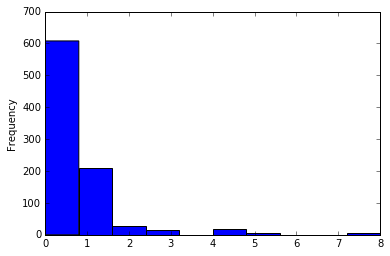

In [46]:
train["SibSp"].plot.hist()

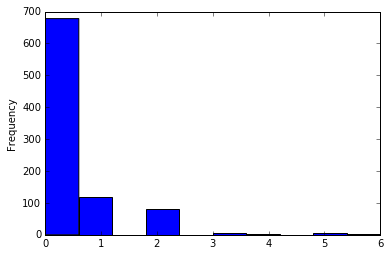

In [47]:
train["Parch"].plot.hist()

In [54]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

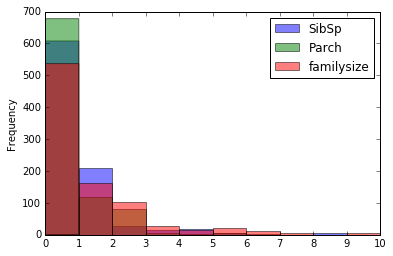

In [63]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()
#There's a lot of overlap on these columns and maybe we can combine
#these two columns and see if it improves our model


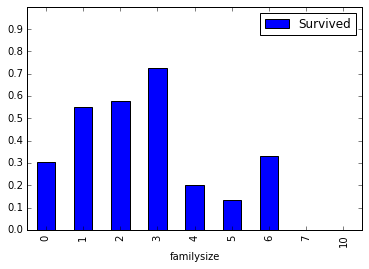

In [65]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index=col,values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

as we can see, only 30% of the passengers who had no family members onboard survived.

Based of this, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

- 1 if the passenger has zero family members onboard
- 0 if the passenger has one or more family members onboard

Let's go ahead and create this feature.

In [66]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

## Select the best features

In [72]:
# scikit-learn's feature_selection.RFECV class to automate 
#selecting the best-performing features using recursive 
#feature elimination.
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


## Selecting and Tuning Different Algorithms


In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,cols)

LogisticRegression
------------------
Best Score: 0.7014590347923682
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------
Best Score: 0.6980920314253648
Best Parameters: {'p': 1, 'n_neighbors': 15, 'algorithm': 'brute', 'weights': 'distance'}

RandomForestClassifier
----------------------
Best Score: 0.7328843995510662
Best Parameters: {'criterion': 'entropy', 'min_samples_split': 5, 'max_depth': 10, 'n_estimators': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}

